In [3]:
!pip install pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [5]:
spark = SparkSession.builder \
    .appName("Property_Price_Regression") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Replace with your actual path
df = spark.read.csv("/content/property.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()


+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+------------------+
only showing top 5 rows

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 

In [8]:
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



# **Combination 1**

In [9]:
input_features = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built']
target = 'Price'


In [10]:
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


In [11]:
data_train, data_test = df.randomSplit([0.7, 0.3], seed=42)


In [12]:
lr = LinearRegression(labelCol=target, featuresCol="scaled_features")
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
model_lr = pipeline_lr.fit(data_train)
pred_lr = model_lr.transform(data_test)

In [13]:
lasso = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=1.0, regParam=0.1)
pipeline_lasso = Pipeline(stages=[assembler, scaler, lasso])
model_lasso = pipeline_lasso.fit(data_train)
pred_lasso = model_lasso.transform(data_test)

In [14]:
ridge = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=0.0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, scaler, ridge])
model_ridge = pipeline_ridge.fit(data_train)
pred_ridge = model_ridge.transform(data_test)

In [15]:
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

# Linear
r2_lr = evaluator_r2.evaluate(pred_lr)
rmse_lr = evaluator_rmse.evaluate(pred_lr)
mse_lr = evaluator_mse.evaluate(pred_lr)

# Lasso
r2_lasso = evaluator_r2.evaluate(pred_lasso)
rmse_lasso = evaluator_rmse.evaluate(pred_lasso)
mse_lasso = evaluator_mse.evaluate(pred_lasso)

# Ridge
r2_ridge = evaluator_r2.evaluate(pred_ridge)
rmse_ridge = evaluator_rmse.evaluate(pred_ridge)
mse_ridge = evaluator_mse.evaluate(pred_ridge)

# Print
print(f"Linear Regression → R²: {r2_lr}, RMSE: {rmse_lr}, MSE: {mse_lr}")
print(f"Lasso Regression  → R²: {r2_lasso}, RMSE: {rmse_lasso}, MSE: {mse_lasso}")
print(f"Ridge Regression  → R²: {r2_ridge}, RMSE: {rmse_ridge}, MSE: {mse_ridge}")


Linear Regression → R²: 0.9941238052556335, RMSE: 19969.214537285974, MSE: 398769529.2361535
Lasso Regression  → R²: 0.994123805530549, RMSE: 19969.214070159935, MSE: 398769510.5798735
Ridge Regression  → R²: 0.9941238049204605, RMSE: 19969.21510679934, MSE: 398769551.981623


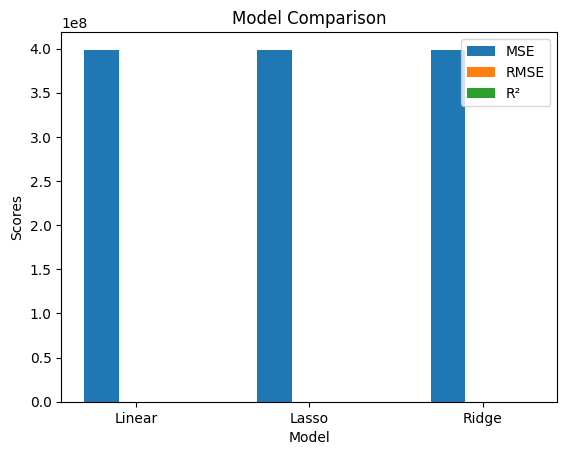

In [16]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear', 'Lasso', 'Ridge']
r2_scores = [r2_lr, r2_lasso, r2_ridge]
rmse_scores = [rmse_lr, rmse_lasso, rmse_ridge]
mse_scores = [mse_lr, mse_lasso, mse_ridge]

x = np.arange(len(models))
width = 0.2

plt.bar(x - width, mse_scores, width, label='MSE')
plt.bar(x, rmse_scores, width, label='RMSE')
plt.bar(x + width, r2_scores, width, label='R²')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()


# **Combination 2**

In [17]:
input_features = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms']
target = 'Price'


In [18]:
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


In [19]:
data_train, data_test = df.randomSplit([0.7, 0.3], seed=42)


In [20]:
lr = LinearRegression(labelCol=target, featuresCol="scaled_features")
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
model_lr = pipeline_lr.fit(data_train)
pred_lr = model_lr.transform(data_test)

In [21]:
lasso = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=1.0, regParam=0.1)
pipeline_lasso = Pipeline(stages=[assembler, scaler, lasso])
model_lasso = pipeline_lasso.fit(data_train)
pred_lasso = model_lasso.transform(data_test)

In [22]:
ridge = LinearRegression(labelCol=target, featuresCol="scaled_features", elasticNetParam=0.0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, scaler, ridge])
model_ridge = pipeline_ridge.fit(data_train)
pred_ridge = model_ridge.transform(data_test)

In [23]:
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

# Linear
r2_lr = evaluator_r2.evaluate(pred_lr)
rmse_lr = evaluator_rmse.evaluate(pred_lr)
mse_lr = evaluator_mse.evaluate(pred_lr)

# Lasso
r2_lasso = evaluator_r2.evaluate(pred_lasso)
rmse_lasso = evaluator_rmse.evaluate(pred_lasso)
mse_lasso = evaluator_mse.evaluate(pred_lasso)

# Ridge
r2_ridge = evaluator_r2.evaluate(pred_ridge)
rmse_ridge = evaluator_rmse.evaluate(pred_ridge)
mse_ridge = evaluator_mse.evaluate(pred_ridge)

# Print
print(f"Linear Regression → R²: {r2_lr}, RMSE: {rmse_lr}, MSE: {mse_lr}")
print(f"Lasso Regression  → R²: {r2_lasso}, RMSE: {rmse_lasso}, MSE: {mse_lasso}")
print(f"Ridge Regression  → R²: {r2_ridge}, RMSE: {rmse_ridge}, MSE: {mse_ridge}")


Linear Regression → R²: 0.9939482556780813, RMSE: 20265.306580776585, MSE: 410682650.81286675
Lasso Regression  → R²: 0.9939482556582234, RMSE: 20265.306614025485, MSE: 410682652.16046506
Ridge Regression  → R²: 0.9939482553242561, RMSE: 20265.307173198893, MSE: 410682674.82410645


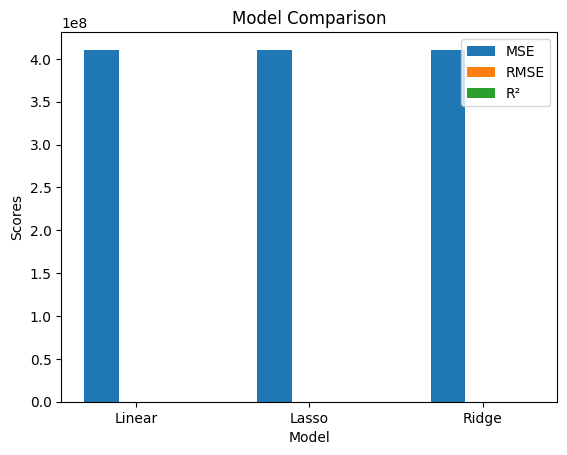

In [24]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear', 'Lasso', 'Ridge']
r2_scores = [r2_lr, r2_lasso, r2_ridge]
rmse_scores = [rmse_lr, rmse_lasso, rmse_ridge]
mse_scores = [mse_lr, mse_lasso, mse_ridge]

x = np.arange(len(models))
width = 0.2

plt.bar(x - width, mse_scores, width, label='MSE')
plt.bar(x, rmse_scores, width, label='RMSE')
plt.bar(x + width, r2_scores, width, label='R²')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()
